# Tutorial: Discover Relationships in a PowerBI Dataset Using Semantic Link
This tutorial is designed to help you explore Azure Fabric data science capabilities, focusing on interaction with PowerBI from Jupyter notebook with the help of SemPy library. 

### In this tutorial, you learn how to:
- Apply domain knowledge to formulate hypotheses about functional dependencies in a dataset;
- Use components of Semantic Link's Python library (SemPy) that supports integration with Power BI and helps to automate data quality analysis. These components include:
    - FabricDataFrame - a pandas-like structure enhanced with additional semantic information;
    - Functions for pulling Power BI datasets from a Fabric workspace into your notebook;
    - Functions that automate the evaluation of hypothesis about functional dependencies and that identify violations of relationships in your datasets.

### Prerequisites

* A [Microsoft Fabric subscription](https://learn.microsoft.com/fabric/enterprise/licenses). Or sign up for a free [Microsoft Fabric (Preview) trial](https://learn.microsoft.com/fabric/get-started/fabric-trial).
* Sign in to [Microsoft Fabric](https://fabric.microsoft.com/).
* Go to the Data Science experience in Microsoft Fabric.
* Select **Workspaces** from the left navigation pane to find and select your workspace. This workspace becomes your current workspace.
* Download the _Customer Profitability Sample.pbix_ and _'Customer Profitability Sample PBIX (auto)_ datasets from the [fabric-samples GitHub repository](https://github.com/microsoft/fabric-samples/blob/09cb40f1ffe0a7cfec67ec0ba2fcfdc95ba750a8/docs-samples/data-science/datasets/Customer%20Profitability%20Sample.pbix) and upload them to your workspace.
* Open your notebook. You have two options:
    * [Import this notebook into your workspace](https://learn.microsoft.com/en-us/fabric/data-engineering/how-to-use-notebook#import-existing-notebooks). You can import from the Data Science homepage.
    * Alternatively, you can create [a new notebook](https://learn.microsoft.com/fabric/data-engineering/how-to-use-notebook#create-notebooks) to copy/paste code into cells.
* In the Lakehouse explorer section of your notebook, add a new or existing lakehouse to your notebook. For more information on how to add a lakehouse, see [Attach a lakehouse to your notebook](https://learn.microsoft.com/en-us/fabric/data-science/tutorial-data-science-prepare-system#attach-a-lakehouse-to-the-notebooks).

## Set up the notebook

In this section, you'll set up a notebook environment with the necessary modules and data.

First, install `SemPy` from PyPI using pip magic command:

In [1]:
%pip install semantic-link

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 151.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.4/754.4 kB 152.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 kB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 77.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 90.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 175.9 MB/s eta 0:00:00

[notic

Then, perform necessary imports of SemPy modules that will be needed later on:

In [19]:
import sempy.fabric as fabric

from sempy.relationships import plot_relationship_metadata
from sempy.relationships import find_relationships
from sempy.fabric import list_relationship_violations

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 26, Finished, Available)

Also import pandas for enforcing a configuration option that will help with output formatting:

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

## Explore PowerBI Datasets

This tutorial uses a standard Power BI sample dataset [Customer Profitability Sample.pbix](https://github.com/microsoft/fabric-samples/tree/09cb40f1ffe0a7cfec67ec0ba2fcfdc95ba750a8/docs-samples/data-science/datasets). For a description of the dataset, see [Customer Profitability sample for Power BI](https://learn.microsoft.com/en-us/power-bi/create-reports/sample-customer-profitability). Start by using SemPy's _list_datasets_ function to explore datasets in your current workspace:

In [3]:
fabric.list_datasets()

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 10, Finished, Available)

,Dataset Name,Dataset ID,Created Timestamp,Last Update
0,AIMLcommunityMap,d646d22d-f053-413e-b3d6-16f391b030d7,1699-12-31 00:00:00,0001-01-01 00:00:00
1,Human Resources Sample,556784dd-7995-4f06-b4d2-cf40acdb601b,2014-07-23 22:14:05,0001-01-01 00:00:00
2,Retail Analysis Sample PBIX,981bc910-afa0-45d8-bc51-cc93c4005b68,2014-05-30 20:16:22,0001-01-01 00:00:00
3,Customer Profitability Sample PBIX,c5b056ff-54bf-4196-bbf2-3a25d37df661,2014-07-22 03:50:22,0001-01-01 00:00:00
4,Customer Profitability Sample PBIX (auto),6968ab28-3e27-4bec-ac7a-80ab844450a6,2014-07-22 03:50:22,0001-01-01 00:00:00
5,Regional Sales Sample,a6738acc-09a3-4fd5-8ae7-001d118fff48,2020-02-08 22:31:17,0001-01-01 00:00:00


For the rest of this notebook we will focus on "Customer Profitability Sample PBIX" in two different flavours:
-  **Customer Profitability Sample PBIX** - the dataset as it comes from PowerBI samples with predefined table relationships
-  **Customer Profitability Sample PBIX (auto)** - the same data but relationships are limited to those that would be auto-detected by PowerBI
 

## Extract a sample dataset with its predefined semantic model

Load relationships that are predefined and stored within the "Customer Profitability Sample PBIX" PowerBI dataset, using SemPy's ``list_relationships`` function which will list from the Tabular Object Model:

In [7]:
dataset = "Customer Profitability Sample PBIX"
relationships = fabric.list_relationships(dataset)
relationships

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 14, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column
0,m:1,Fact,BU Key,BU,BU Key
1,m:1,Fact,YearPeriod,Date,YearPeriod
2,m:1,Fact,Scenario Key,Scenario,Scenario Key
3,m:1,Fact,Product Key,Product,Product Key
4,m:1,Fact,Customer Key,Customer,Customer
5,m:1,BU,Executive_id,Executive,ID
6,m:1,Customer,Industry ID,Industry,ID
7,m:1,Customer,State,State,StateCode


We can visualize the relationships dataframe as a graph with another function from SemPy library called ``plot_relationship_metadata``:

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 15, Finished, Available)

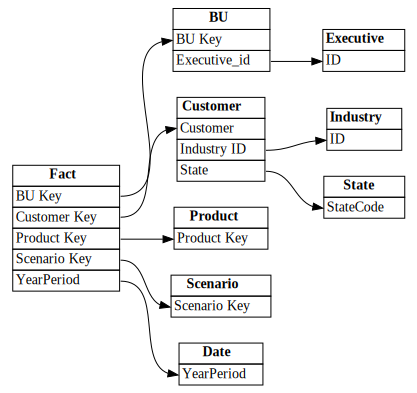

In [8]:
plot_relationship_metadata(relationships)

This is "ground truth" for relationships between tables in this dataset, as it reflects how they were defined by a subject matter expert in PowerBI.

## Complement relationships discovery

If we started with relationships that were auto-detected by PowerBI, we would have a smaller set:

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 16, Finished, Available)

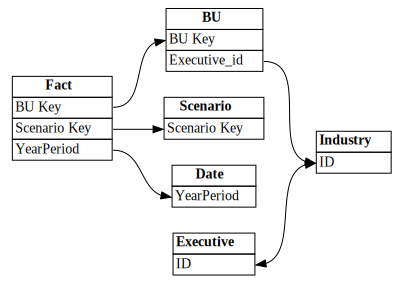

In [9]:
dataset = "Customer Profitability Sample PBIX (auto)"
autodetected = fabric.list_relationships(dataset)
plot_relationship_metadata(autodetected)

As we see, PowerBI autodetection missed many relationships. Morevoer, two of auto-detected relationships are semantically incorrect:

* Executive[ID]->Industry[ID]
* BU[Executive_id]->Industry[ID]

Get rid of incorrectly identified relationships. First, print out the relationships as a table:

In [10]:
autodetected

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 17, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column
0,m:1,Fact,BU Key,BU,BU Key
1,m:1,Fact,Scenario Key,Scenario,Scenario Key
2,m:1,Fact,YearPeriod,Date,YearPeriod
3,1:1,Executive,ID,Industry,ID
4,m:1,BU,Executive_id,Industry,ID


Incorrect relationships to table _Industry_ appear in rows with index 3 and 4. We can use this information to remove these rows.

In [11]:
autodetected.drop(index=[3,4], inplace=True)
autodetected

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 18, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column
0,m:1,Fact,BU Key,BU,BU Key
1,m:1,Fact,Scenario Key,Scenario,Scenario Key
2,m:1,Fact,YearPeriod,Date,YearPeriod


After this cleanup, we have correct, but incomplete relationships, as the visualization with _plot_relationship_metadata_ shows:

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 19, Finished, Available)

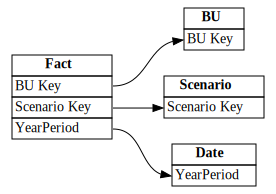

In [12]:
plot_relationship_metadata(autodetected)

With SemPy's _list_tables_ and _read_table_ functions, load all the tables from the dataset:

In [14]:
tables = {table: fabric.read_table(dataset, table) for table in fabric.list_tables(dataset)['Name']}

tables.keys()

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 21, Finished, Available)

dict_keys(['Fact', 'BU', 'Date', 'Scenario', 'Product', 'Customer', 'Industry', 'Executive', 'State'])

Find relationships between tables using _find_relationships_ and review log output to get some insights into how this function works:

In [16]:
suggested_relationships_all = find_relationships(
    tables,
    name_similarity_threshold=0.7,
    coverage_threshold=0.7,
    verbose=2
)

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 23, Finished, Available)

Searching for relationships between tables Fact and BU
  Columns BU Key and BU Key
  Columns BU Key and BU
    Detected BU Key->BU Key coverage: (1.0, 0.15853658536585366)
Searching for relationships between tables Fact and Date
  Columns YearPeriod and YearPeriod
  Columns YearPeriod and Period
    Detected YearPeriod->YearPeriod coverage: (1.0, 0.19047619047619047)
Searching for relationships between tables Fact and Scenario
  Columns Scenario Key and Scenario Key
  Columns Scenario Key and Scenario
    Detected Scenario Key->Scenario Key coverage: (1.0, 1.0)
Searching for relationships between tables Fact and Product
  Columns Product Key and Product Key
  Columns Product Key and Product
    Detected Product Key->Product Key coverage: (0.8571428571428571, 1.0)
Searching for relationships between tables Fact and Customer
  Columns Customer Key and Customer
  Columns Customer Key and Name
    Detected Customer Key->Customer coverage: (0.7666666666666667, 0.21100917431192662)
Searching

Visualize newly discovered relationships:

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 24, Finished, Available)

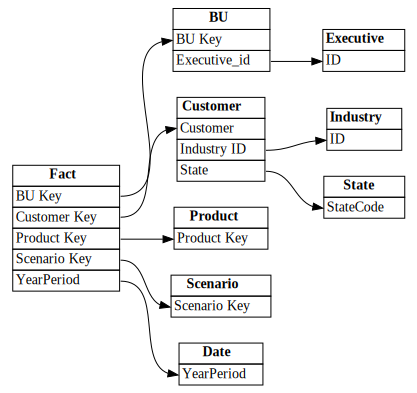

In [17]:
plot_relationship_metadata(suggested_relationships_all)

SemPy was able to detect all relationships! To limit the search to additional relationships that have not been identified previously, use "exclude" parameter:

In [18]:
additional_relationships = find_relationships(
    tables,
    exclude=autodetected,
    name_similarity_threshold=0.7,
    coverage_threshold=0.7
)

additional_relationships

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 25, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column,Coverage From,Coverage To,Null Count From,Null Count To,Unique Count From,Unique Count To,Row Count From,Row Count To
0,m:1,Fact,Product Key,Product,Product Key,0.857143,1.000000,0,0,7,6,47646,6
1,m:1,Fact,Customer Key,Customer,Customer,0.766667,0.211009,0,0,90,327,47646,327
2,m:1,BU,Executive_id,Executive,ID,1.000000,0.888889,0,0,8,9,164,9
3,m:1,Customer,Industry ID,Industry,ID,0.968750,0.911765,0,0,32,34,327,34
4,m:1,Customer,State,State,StateCode,0.891892,0.647059,0,0,37,51,327,51


## Validate data

In order to validate the relationships, we need to load the data from PowerBI "Customer Profitability Sample PBIX" dataset first:

In [20]:
dataset = "Customer Profitability Sample PBIX"
tables = {table: fabric.read_table(dataset, table) for table in fabric.list_tables(dataset)['Name']}

tables.keys()

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 27, Finished, Available)

dict_keys(['Fact', 'BU', 'Date', 'Scenario', 'Product', 'Customer', 'Industry', 'Executive', 'State'])

Once we have the data, we can check for overlap of primary and foreign key values using `list_relationship_violations`. As an argument, we supply the output of `list_relationships` function:

In [24]:
list_relationship_violations(tables, fabric.list_relationships(dataset))

StatementMeta(, a32763e8-955f-4644-a1ca-b314213819d2, 31, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column,Type,Message
0,m:1,Fact,Customer Key,Customer,Customer,partial join,"21 out of 90 values in Fact[Customer Key] not present in Customer[Customer]: 1042,1041,1044,1045,1024,1002,1000,1010,1032,1017,..."
1,m:1,Fact,Product Key,Product,Product Key,partial join,1 out of 7 values in Fact[Product Key] not present in Product[Product Key]: 50
2,m:1,Customer,State,State,StateCode,partial join,"4 out of 37 values in Customer[State] not present in State[StateCode]: ON,MX,MB,NSW"
3,m:1,Customer,Industry ID,Industry,ID,partial join,1 out of 32 values in Customer[Industry ID] not present in Industry[ID]: 31


This provides us interesting insights, such as that  one out of 7 values in Fact[Product Key] is not present in Product[Product Key], and this missing key is 50.

Exploratory data analysis is an exciting process, and so is data cleaning. There's always something that the data is hiding, depending on how you look at it, what you want to ask, and so on. Semantic Link provides you with new tools that you can use to achieve more with your data. 

## Next step

Try using the learned ways of detecting data quality issues on your data and get amazed with the discoveries!

In [ ]:
## Related content

Check out other tutorials for Semantic Link / SemPy:
1. Clean Data with Functional Dependencies
1. Detect Relationships in SYNTHEA dataset
1. Analyze functional dependencies in a Power BI sample dataset
1. Extract and Calculate PowerBI Measures from Jupyter Notebook